<a href="https://colab.research.google.com/github/Mhtag/tensorflow/blob/main/12_saving_and_loading__models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install -U tensorflow_hub
!pip install -U tensorflow_datasets

In [15]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import time
import matplotlib.pyplot as plt


In [16]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    split = ['train[80%:]','train[:80%]'],
    with_info=True,
    as_supervised=True,
)


In [17]:
def format_image(image, label):
  image = tf.image.resize(image,(224,224))/255.0
  return image, label

num_examples = info.splits['train'].num_examples

train_batches = train_examples.cache().shuffle(num_examples//4).map(format_image).batch(32).prefetch(1)
validation_batches = validation_examples.cache().map(format_image).batch(32).prefetch(1)

In [18]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(224,224,3))

In [19]:
feature_extractor.trainable=False

In [20]:
model = tf.keras.Sequential([
                             feature_extractor,
                             tf.keras.layers.Dense(2)])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
history = model.fit(train_batches,
                    epochs=1,
                    validation_data=validation_batches)

146/146 [==============================] - 618s 4s/step - loss: 0.0974 - accuracy: 0.9654 - val_loss: 0.0480 - val_accuracy: 0.9843


In [25]:
class_names =np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [26]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predict_batch = model.predict(image_batch)
predict_batch = tf.squeeze(predict_batch).numpy()
predicted_ids = np.argmax(predict_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names


array(['dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat',
       'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat',
       'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog',
       'dog', 'cat', 'cat', 'dog', 'cat'], dtype='<U3')

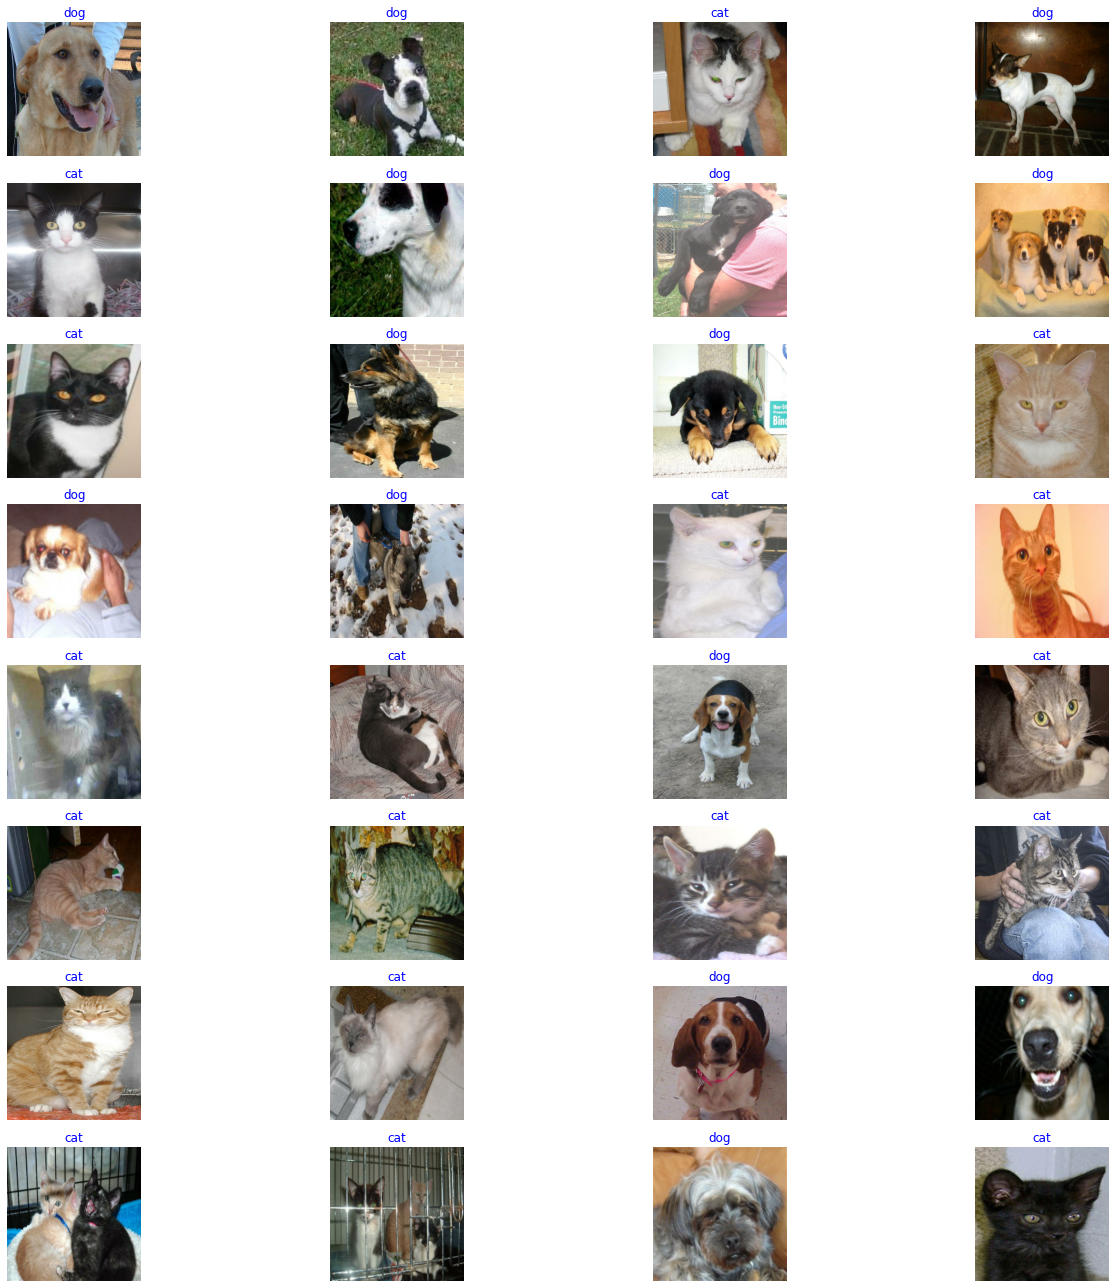

In [28]:
plt.figure(figsize=(20,18))
for n in range(32):
  plt.subplot(8,4,n+1)
  plt.axis('off')
  plt.imshow(image_batch[n])
  color = 'blue' if predicted_ids[n] == label_batch[n] else 'red'
  plt.title(predicted_class_names[n], color=color)
plt.tight_layout()
plt.show()

In [32]:
t = time.time()

export_path = f'./time_{int(t)}'
print(export_path)

tf.saved_model.save(model, export_path)

./time_1634217519
INFO:tensorflow:Assets written to: ./time_1634217519/assets


INFO:tensorflow:Assets written to: ./time_1634217519/assets


In [33]:
!zip -r model.zip {export_path}

  adding: time_1634217519/ (stored 0%)
  adding: time_1634217519/variables/ (stored 0%)
  adding: time_1634217519/variables/variables.index (deflated 78%)
  adding: time_1634217519/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: time_1634217519/assets/ (stored 0%)
  adding: time_1634217519/saved_model.pb (deflated 92%)


In [34]:
try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>